# Prévisions météorologiques en Australie

# Séries temporelles : prévisions de la pluie à J+3 et J+7

## Récupération des librairies

In [1]:
!pip3 install tqdm

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sklearn
import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## Récupération du jeu de données et analyse d'une série temporelle

In [3]:
# récupération du jeu de données après prétraitement et avant l'étape de classification des villes en fonction du climat
df = pd.read_csv('../data/weatherAUS_preprocessed_before_city_clust.csv', header=0, parse_dates=[0], squeeze=True)
df.head()

,Date,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
0,2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0
1,2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0
2,2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0
3,2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0
4,2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0


In [4]:
# analyse statistique rapide du DataFrame
df.describe()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
count,140787.000000,140787.000000,140787.000000,140787.00000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,0.485723,7.464155,39.774027,51.45039,1017.675010,4.508919,21.704255,0.221618,11.047056,-17.432103
std,0.791851,3.180147,12.945712,20.80663,7.020096,2.217188,6.915140,0.415337,4.955324,16.392319
min,0.000000,0.000000,6.000000,0.00000,998.650000,0.000000,1.900000,0.000000,-3.750000,-63.500000
25%,0.000000,6.160000,31.000000,37.00000,1012.900000,3.000000,16.600000,0.000000,7.200000,-29.000000
50%,0.000000,7.630540,39.000000,52.00000,1017.600000,4.499250,21.100000,0.000000,10.500000,-17.000000
75%,0.800000,9.680000,48.000000,66.00000,1022.400000,6.000000,26.400000,0.000000,14.500000,-6.000000
max,2.000000,14.500000,73.500000,100.00000,1036.650000,9.000000,41.100000,1.000000,25.450000,28.500000


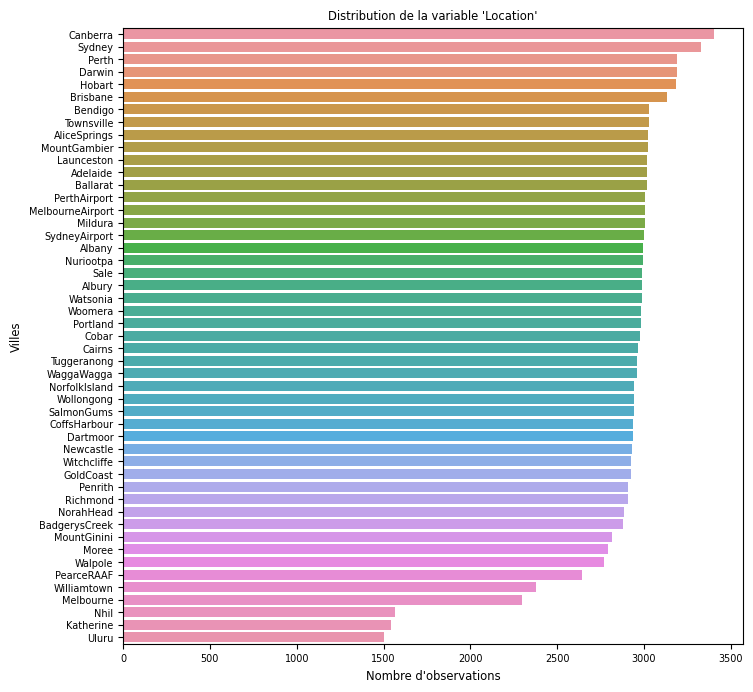

In [5]:
# distribution de la variable 'Location'
plt.figure(figsize=(8,8))
ax = sns.countplot(y=df['Location'], order=df['Location'].value_counts().index)
ax.set_title("Distribution de la variable 'Location'", fontsize="small")
ax.set_ylabel('Villes', fontsize="small")
ax.set_xlabel("Nombre d'observations", fontsize="small")
ax.tick_params(labelsize=7);

In [6]:
# récupération de la ville possédant le plus d'observations
city_with_max_obs = df['Location'].value_counts().sort_values(ascending=False).idxmax()
print("Ville possédant le plus d'observations : ", city_with_max_obs)

Ville possédant le plus d'observations :  Canberra


In [7]:
# filtrage du DataFrame selon la ville sélectionnée
df_city = df[df["Location"] == city_with_max_obs]

In [8]:
# étude statistique descriptive rapide pour la ville sélectionnée
df_city.describe()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
count,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000,3402.000000
mean,0.396767,6.937738,40.123457,45.840976,1018.784965,4.759522,19.488536,0.183715,14.129424,-27.282334
std,0.743219,3.270229,13.066391,18.100352,7.379713,2.397162,6.897487,0.387309,5.024148,16.000244
min,0.000000,0.000000,11.000000,4.000000,998.650000,0.000000,3.700000,0.000000,1.400000,-63.500000
25%,0.000000,4.940000,31.000000,34.000000,1013.700000,3.000000,13.800000,0.000000,10.400000,-39.000000
50%,0.000000,7.630540,39.000000,44.000000,1018.700000,4.499250,18.850000,0.000000,14.400000,-28.000000
75%,0.200000,9.215000,48.000000,56.000000,1023.800000,7.000000,24.500000,0.000000,17.900000,-17.000000
max,2.000000,13.600000,73.500000,99.000000,1036.650000,8.000000,39.500000,1.000000,25.450000,28.500000


In [9]:
# étude statistique descriptive rapide pour la ville sélectionnée
df_city.describe(include=[object])

,Location
count,3402
unique,1
top,Canberra
freq,3402


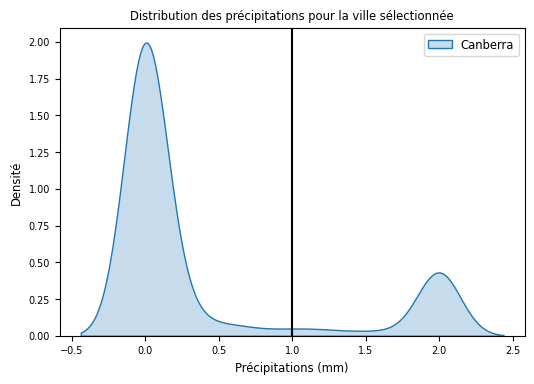

In [10]:
# distribution des précipitations pour la ville sélectionnée
plt.figure(figsize=(6,4))
ax = sns.kdeplot(df_city['Rainfall'], shade='True', label=city_with_max_obs)
ax.set_title("Distribution des précipitations pour la ville sélectionnée", fontsize="small")
ax.set_ylabel('Densité', fontsize="small")
ax.set_xlabel("Précipitations (mm)", fontsize="small")
plt.axvline(x=1, color='black')
ax.legend(fontsize="small")
ax.tick_params(labelsize=7);

In [11]:
# remplacement de l'index du DataFrame par conversion de la variable "Date" au format datetime
df_city.index = pd.to_datetime(df_city['Date'], format='%Y-%m-%d')
df_city['month'] = pd.to_datetime(df_city['Date']).dt.month
df_city['year'] = pd.to_datetime(df_city['Date']).dt.year
df_city.drop('Date', axis=1, inplace=True)

In [12]:
# aperçu du DataFrame
df_city.head()

,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,month,year
Date,,,,,,,,,,,,,
2007-11-01,Canberra,0.0,6.3,30.0,29.0,1019.7,7.0,23.6,1,16.3,-39.0,11,2007
2007-11-02,Canberra,2.0,9.7,39.0,36.0,1012.4,3.0,25.7,1,12.9,-44.0,11,2007
2007-11-03,Canberra,2.0,3.3,73.5,69.0,1009.5,7.0,20.2,1,9.7,-13.0,11,2007
2007-11-04,Canberra,2.0,9.1,54.0,56.0,1005.5,7.0,14.1,1,2.2,-6.0,11,2007
2007-11-05,Canberra,2.0,10.6,50.0,49.0,1018.3,7.0,15.4,0,8.5,-19.0,11,2007


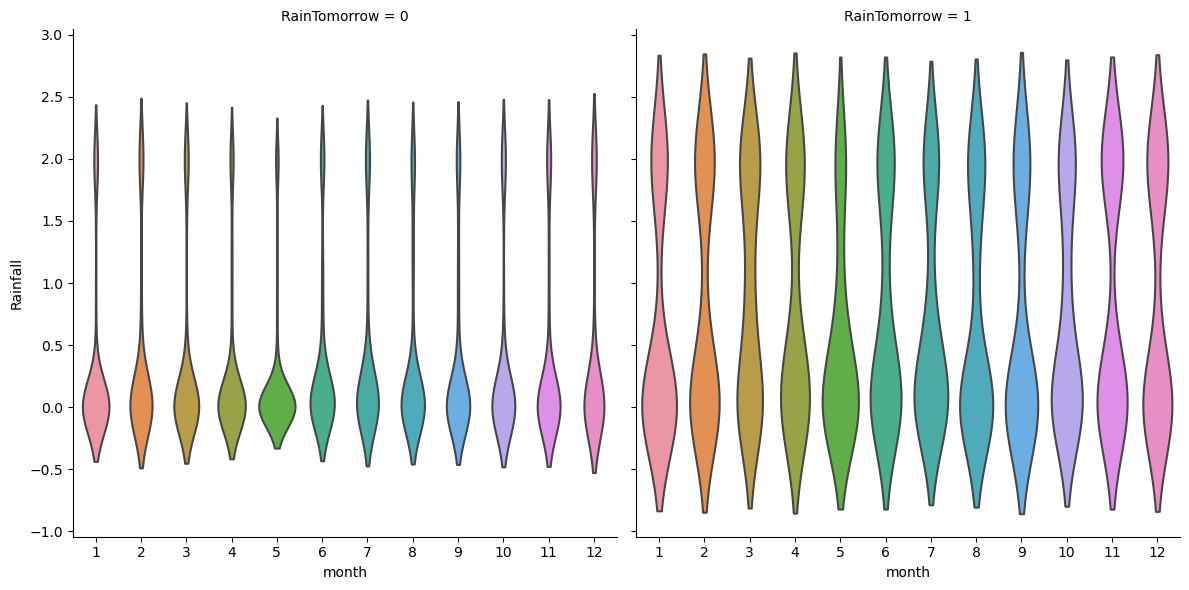

In [13]:
# distribution des précipitations avec les courbes de densité pour chaque modalité de la variable "RainTomorrow" 
# et pour chaque mois de la période observée
sns.catplot(kind='violin', x='month', y='Rainfall', data=df_city, col='RainTomorrow', inner=None, height=6, col_wrap=2);

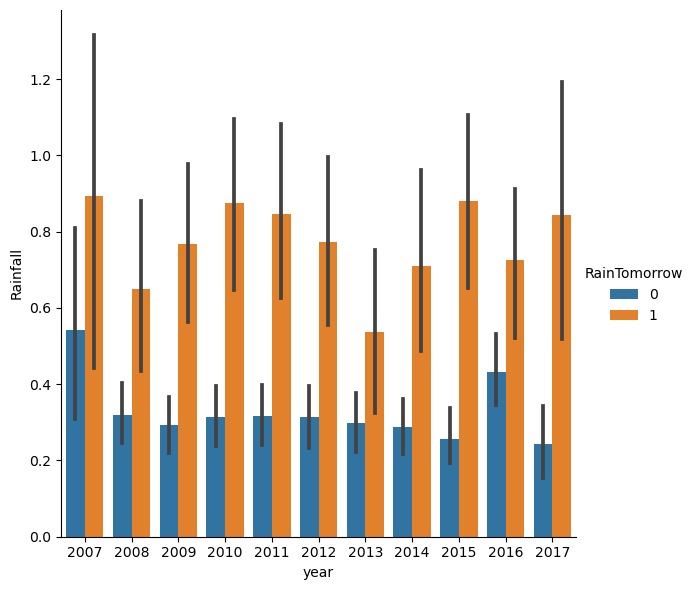

In [14]:
# graphique en barres des précipitations selon les modalités de la variable "RainTomorrow"
sns.catplot(x='year', y='Rainfall', kind='bar', height=6, hue='RainTomorrow', data=df_city);

In [15]:
df_city = df_city[["Rainfall","RainTomorrow","month","year"]]

In [16]:
# répartition du nombre de jours d'observations pour chaque année selon les valeurs de "RainTomorrow"
pd.crosstab(df_city.year, df_city.RainTomorrow).sort_values(by='year', ascending=True)

RainTomorrow,0,1
year,,
2007,42,19
2008,303,63
2009,301,64
2010,292,72
2011,260,59
2012,272,61
2013,284,53
2014,299,62
2015,296,62


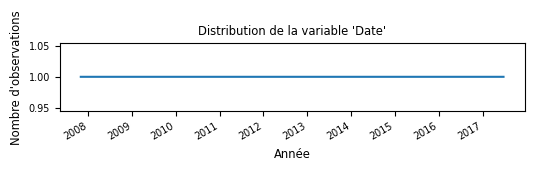

In [17]:
# affichage de la distribution de la variable 'Date'
plt.figure(figsize=(6,1))
df_city.Rainfall.groupby(['Date']).size().plot()
plt.title("Distribution de la variable 'Date'", fontsize="small")
plt.xlabel("Année", fontsize="small")
plt.ylabel("Nombre d'observations", fontsize="small")
plt.tick_params(labelsize=7);

- la série temporelle filtrée couvre bien toute la période considérée pour la ville sélectionnée.

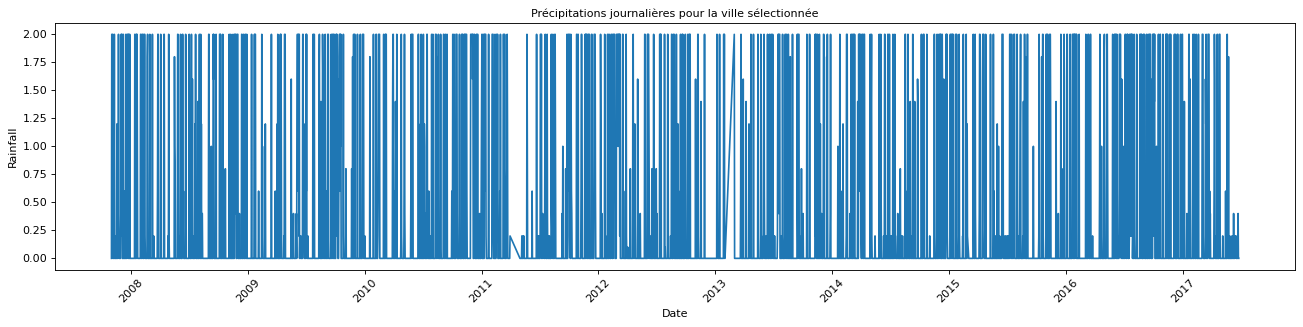

In [18]:
plt.figure(figsize=(20,4), dpi=80)
plt.ylabel('Rainfall')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Précipitations journalières pour la ville sélectionnée', fontsize='medium')
plt.plot(df_city.Rainfall.index, df_city.Rainfall);

In [19]:
# calcul de la moyenne mobile centrée sur une semaine
df_city_week_mean = df_city.rolling(window='7D', center=True).mean()
df_city_week_std = df_city.rolling(window='7D', center=True).std()

In [20]:
# calcul de la moyenne mobile centrée sur un mois
df_city_month_mean = df_city.rolling(window='30D', center=True).mean()

In [21]:
# calcul de la moyenne mobile centrée sur une année
df_city_year_mean = df_city.rolling(window='365D', center=True).mean()

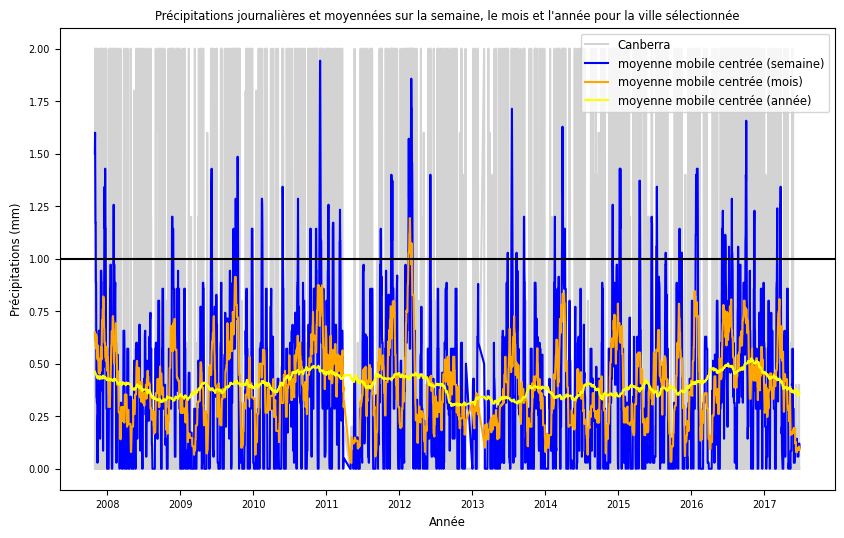

In [22]:
# affichage de la série temporelle originale et des moyenne mobiles centrées
plt.figure(figsize=(10,6))
plt.plot(df_city.Rainfall, color='lightgray', label=city_with_max_obs)
plt.plot(df_city_week_mean.Rainfall, color='blue', label='moyenne mobile centrée (semaine)')
plt.plot(df_city_month_mean.Rainfall, color='orange', label='moyenne mobile centrée (mois)')
plt.plot(df_city_year_mean.Rainfall, color='yellow', label='moyenne mobile centrée (année)')
plt.xlabel("Année", fontsize="small")
plt.ylabel("Précipitations (mm)", fontsize="small")
plt.axhline(y=1, color='black')
plt.legend(loc='upper right', fontsize="small")
plt.title("Précipitations journalières et moyennées sur la semaine, le mois et l'année pour la ville sélectionnée", 
          fontsize="small")
plt.tick_params(labelsize=7);

La moyenne mobile centrée permet d'identifier la tendance de la série originale pour les précipitations moyennées au cours du temps: 
- à la semaine: présente de très grandes variations et n'augmente pas
- au mois: présente de grandes variations et n'augmente pas
- à l'année: présente une faible variation et n'augmente pas

In [24]:
# affichage de l'index
print(df_city.index)

DatetimeIndex(['2007-11-01', '2007-11-02', '2007-11-03', '2007-11-04',
               '2007-11-05', '2007-11-06', '2007-11-07', '2007-11-08',
               '2007-11-09', '2007-11-10',
               ...
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', length=3402, freq=None)


- La série temporelle filtrée contient des observations journalières pour la période du **1er Novembre 2007** au **25 Juin 2017**.

## Décomposition automatique de la série temporelle

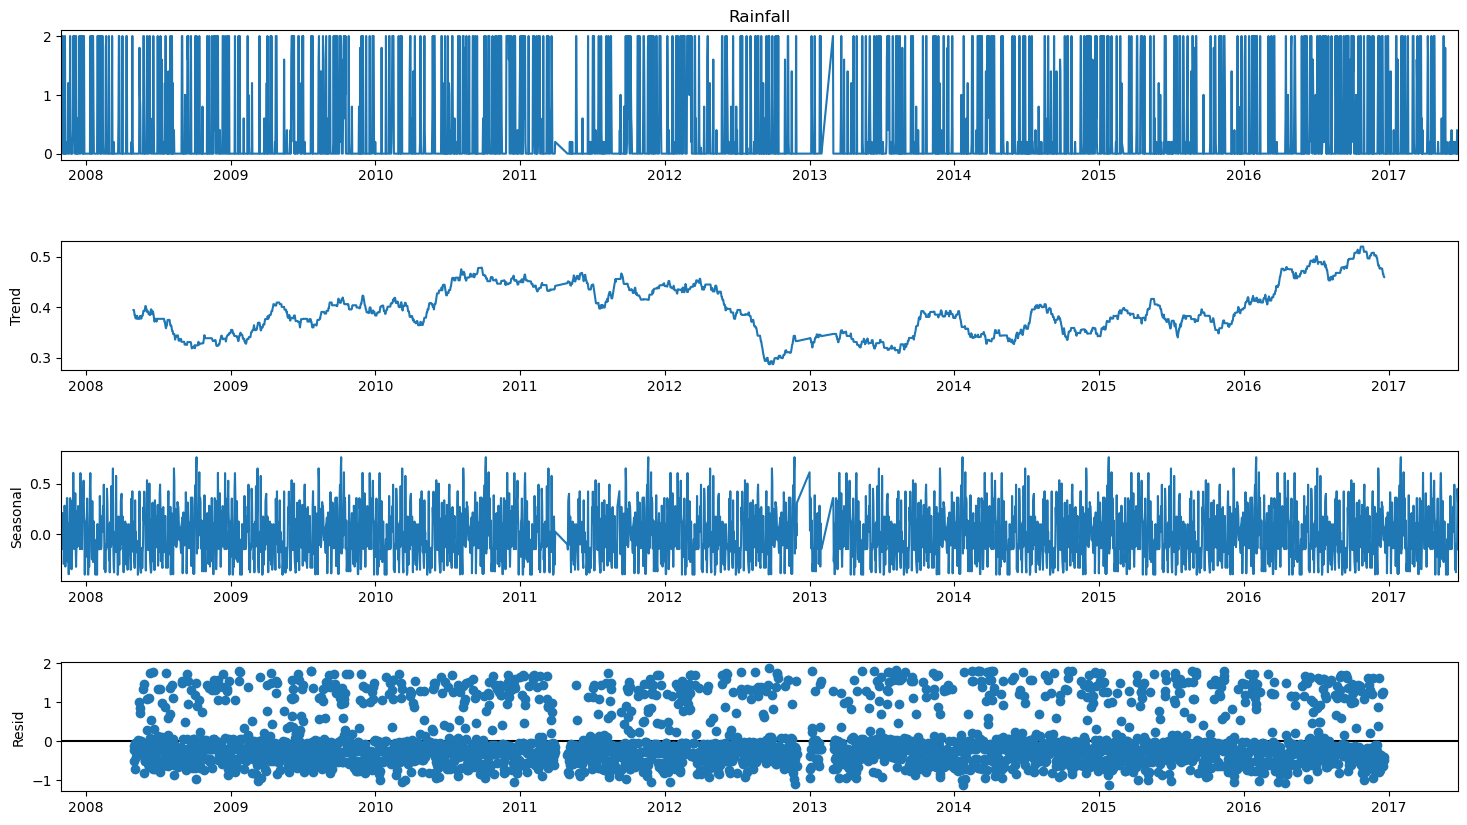

In [25]:
# décomposition automatique de la série temporelle identifiant la tendance, la saisonalité et le résidu
res = seasonal_decompose(df_city.Rainfall, period=365, model='additive')
fig = res.plot()
fig.set_size_inches((16, 9));

- La tendance met en évidence les années de faibles et fortes précipitations,
- La saisonalité conserve une ampleur constante au cours du temps,
- Le résidu présente des grandes variations en fonction du temps, il ne peut pas être assimilé à une suite de variables aléatoires non corrélées et de variance finie, c'est à dire à un bruit blanc faible.

## Entraînement d'un modèle ARIMA

### Autocorrélation et différenciation

In [26]:
# test de l'Augmented Dickey-Fuller
def adfuller_test(rain):
    result = adfuller(rain)
    labels = ['ADF Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        
adfuller_test(df_city.Rainfall)

ADF Statistic : -44.55065999449636
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 3401


p-value < 0,05 : nous pouvons rejeter l'hypothèse nulle (H0), les données n'ont pas de racine unitaire et sont stationnaires.

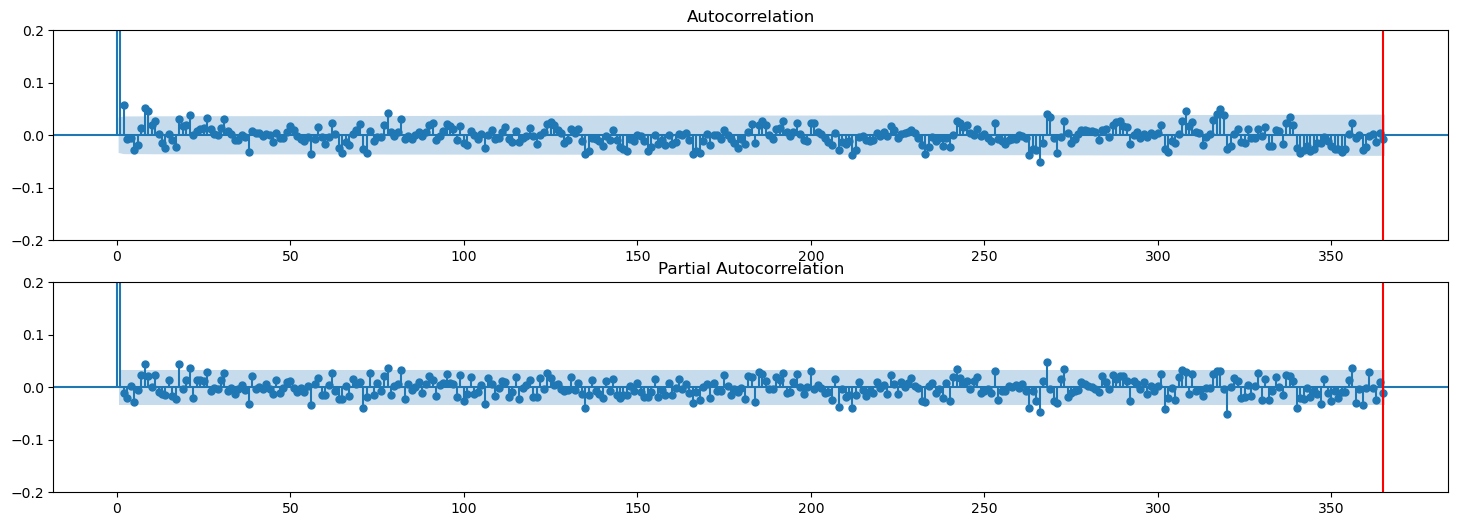

In [27]:
# affichage sur 365 décalages des autocorrélogrammes simple et partiel de la série
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,6))
plot_acf(df_city.Rainfall, lags=365, ax=ax1)
ax1.axvline(x=365, color='red')
ax1.set_ylim(-0.2,0.2)
plot_pacf(df_city.Rainfall, lags=365, ax=ax2)
ax2.axvline(x=365, color='red')
ax2.set_ylim(-0.2,0.2);

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) tend vers 0

In [28]:
# différentiation en saisonalité sur "df_city_rain"
df_city_rain_1 = df_city.Rainfall.diff(periods=365).dropna()

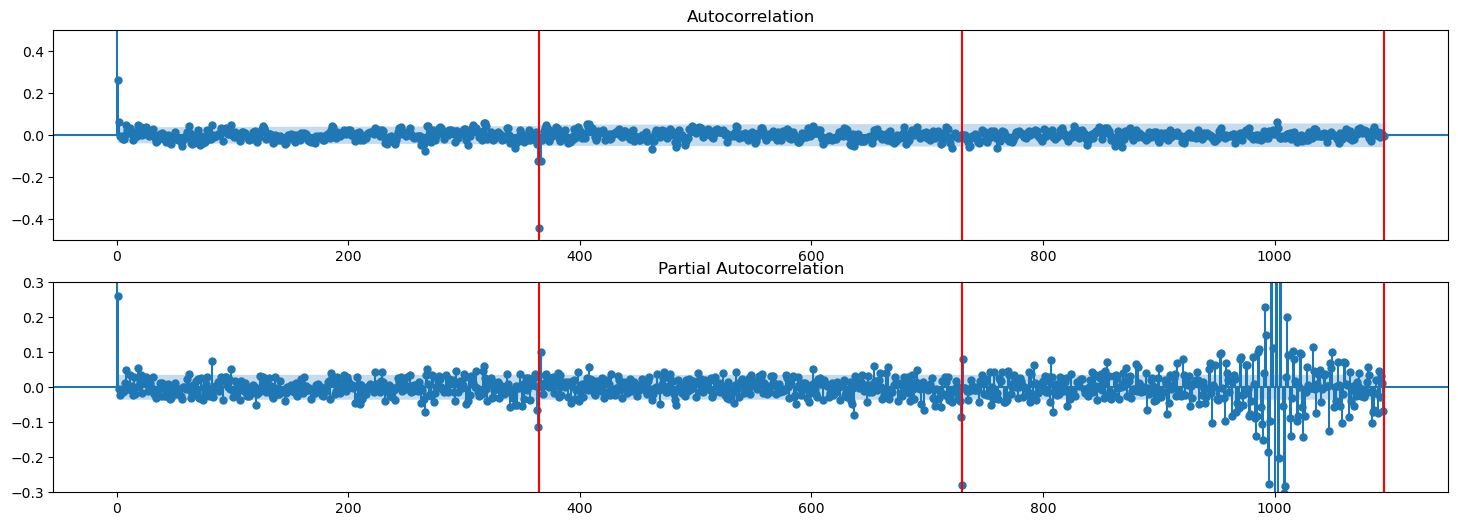

In [29]:
# affichage sur 365*3 décalages des autocorrélogrammes simple et partiel de la série doublement différenciée
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,6))
plot_acf(df_city_rain_1, lags=365*3, ax=ax1)
ax1.axvline(x=365, color='red')
ax1.axvline(x=365*2, color='red')
ax1.axvline(x=365*3, color='red')
ax1.set_ylim(-0.5,0.5)
plot_pacf(df_city_rain_1, lags=365*3, ax=ax2)
ax2.axvline(x=365, color='red')
ax2.axvline(x=365*2, color='red')
ax2.axvline(x=365*3, color='red');
ax2.set_ylim(-0.3,0.3);

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) ne semble pas tendre vers 0

Comme les données sont déjà stationnaires, nous allons ignorer la différentiation en saisonalité. 

### Entraînement et sélection du modèle

In [30]:
# entraînement du modèle ARIMA et calcul de la MSE en fonction des ordres p, d et q
def evaluate_arima_model(X, arima_order, thres):
    train_size = int(len(X) * thres)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

In [31]:
# évaluation du modèle ARIMA en fonction des ordres p, d et q
def evaluate_models(dataset, p_values, d_values, q_values, thres):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order, thres)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [32]:
# séparation des données des précipitations entre un jeu d'entraînement et un jeu de test 
threshold = 0.8
train_size = int(len(df_city.Rainfall.values) * threshold)
df_train, df_test = df_city.Rainfall.values[0:train_size], df_city.Rainfall.values[train_size:]
print(f"{len(df_train)} jours pour le jeu d'entraînement \n {len(df_test)} jours pour le jeu de test \n")

2721 jours pour le jeu d'entraînement 
 681 jours pour le jeu de test 



In [33]:
# récupération de la date à l'intersection du jeu d'entraînement et du jeu de test
date_train_test = df_city.index[len(df_train)].strftime("%Y-%m-%d")
date_train_test

'2015-08-07'

In [34]:
# définition de la grille de recherche et exécution en série du modèle ARIMA pour déterminer les ordres optimisant la MSE
p_values = [0]
d_values = [0,1,2]
q_values = [0,1,2]

best_order = evaluate_models(df_city.Rainfall.values, p_values, d_values, q_values, threshold)

100%|██████████| 681/681 [03:35<00:00,  3.16it/s]


ARIMA(0, 0, 0) MSE=0.581


100%|██████████| 681/681 [02:24<00:00,  4.71it/s]


ARIMA(0, 0, 1) MSE=0.552


100%|██████████| 681/681 [04:24<00:00,  2.57it/s]


ARIMA(0, 0, 2) MSE=0.548


100%|██████████| 681/681 [12:32<00:00,  1.10s/it]

Best ARIMA(0, 0, 2) MSE=0.548


In [35]:
# affichage de la configuration réduisant le plus la MSE
best_order

(0, 0, 2)

In [36]:
# calcul des prévisions des précipitations sur le jeu de test
index = len(df_train)
yhat = list()

for t in tqdm(range(len(df_test))):
    temp_train = df_city[:len(df_train)+t]
    model = ARIMA(temp_train.Rainfall, order=best_order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
yhat = pd.concat(yhat)

100%|██████████| 681/681 [04:27<00:00,  2.55it/s]


In [37]:
# calcul du ratio sur les valeurs maximales entre les mesures et les prédictions afin d'adapter la valeur de Rainfall définissant si il pleut le lendemain   
ratio = df_test.max() / yhat.max()
ratio

2.3446941675941058

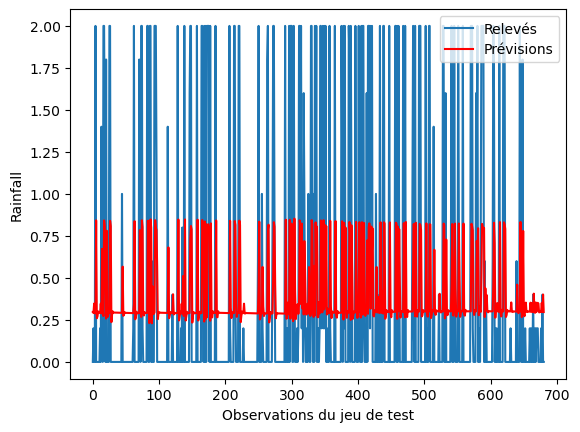

In [38]:
# représentation des observations et des prévisions des précipitations sur le jeu de test
plt.plot(df_test, label='Relevés')
plt.plot(yhat.values, color='red', label='Prévisions')
plt.xlabel('Observations du jeu de test')
plt.ylabel('Rainfall')
plt.legend(loc='upper right');

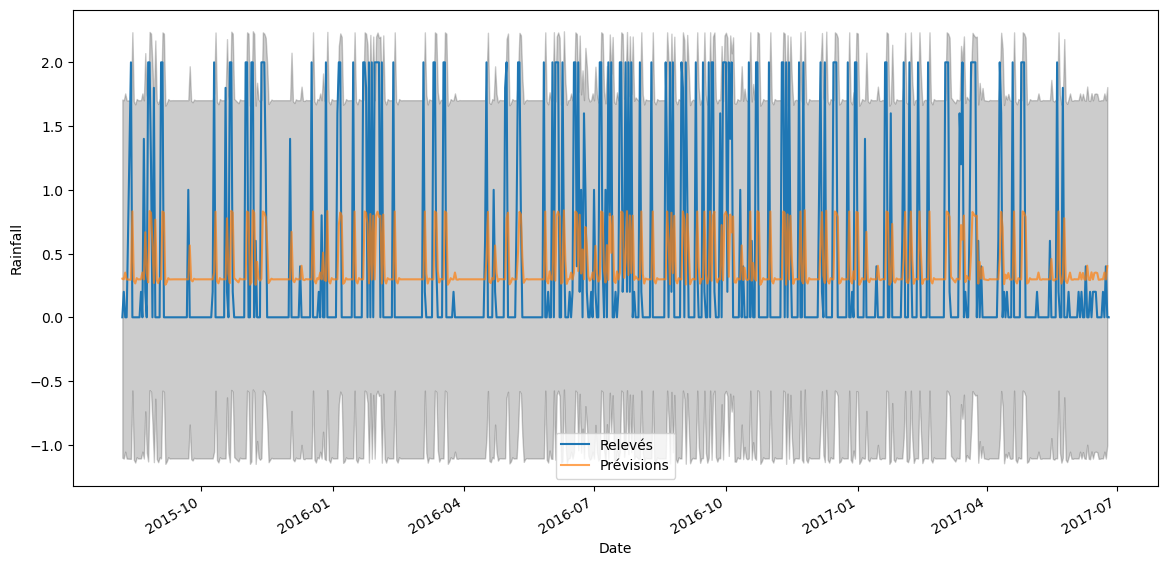

In [39]:
# visualisation de la moyenne et de l'intervalle de confiance sur le jeu de test
pred = model_fit.get_prediction(start=pd.to_datetime(date_train_test), dynamic=False)
pred_ci = pred.conf_int()
y = df_city.Rainfall

ax = y[date_train_test:].plot(label='Relevés')
pred.predicted_mean.plot(ax=ax, label='Prévisions', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')
plt.legend(loc='lower center');

In [40]:
# calcul de la précision du modèle ARIMA
y_pred = pred.predicted_mean
y_reel = y[date_train_test:]

mse = ((y_pred-y_reel)**2).mean()
print('Mean Squared Error: {}'.format(round(mse,2)))
print('Root Mean Squared Error: {}'.format(round(np.sqrt(mse),2)))

Mean Squared Error: 0.55
Root Mean Squared Error: 0.74


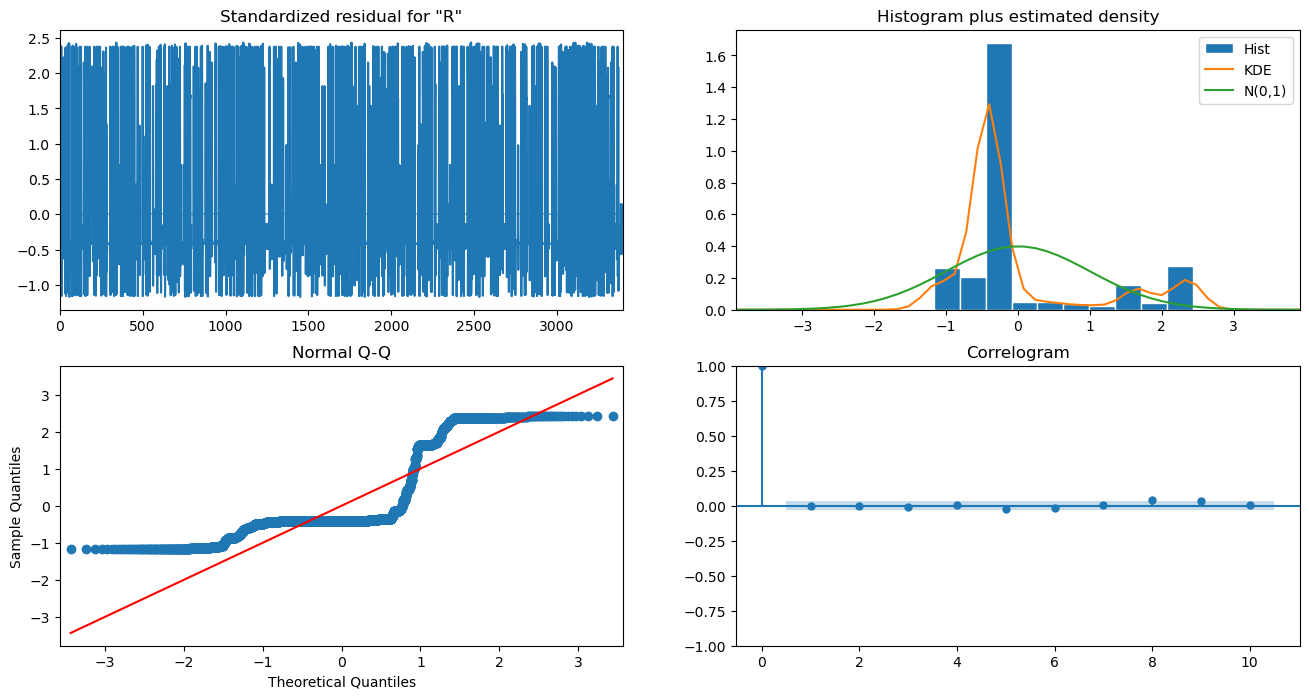

In [41]:
model_fit.plot_diagnostics(figsize=(16, 8));

In [42]:
# résultats du modèle ARIMA
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Rainfall   No. Observations:                 3401
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -3693.932
Date:                Wed, 07 Dec 2022   AIC                           7395.864
Time:                        12:20:28   BIC                           7420.392
Sample:                             0   HQIC                          7404.631
                               - 3401                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3968      0.053      7.469      0.000       0.293       0.501
ma.L1          0.2661      0.022     12.192      0.000       0.223       0.309
ma.L2          0.0657      0.018      3.606      0.0

In [43]:
# définition d'un modèle ARIMA reprenant les résultats précédent et entraîné sur le jeu d'entraînement uniquement
model = ARIMA(df_train, order=best_order)
arima = model.fit()

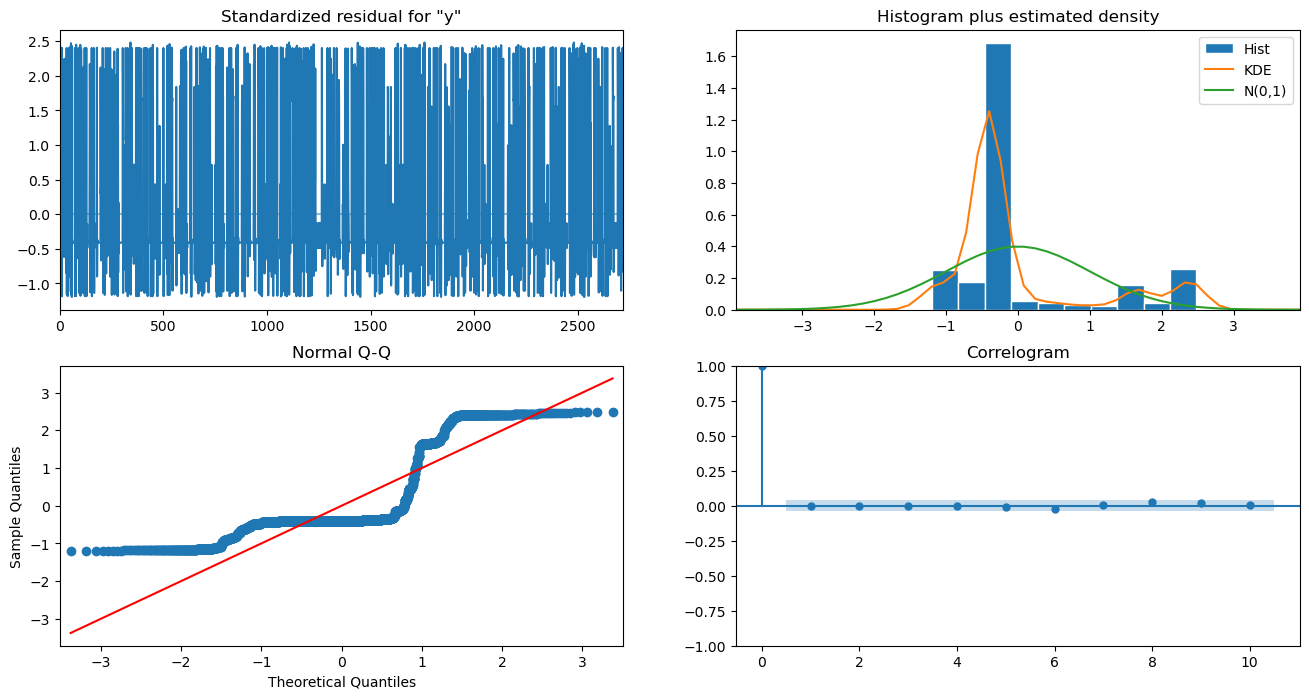

In [44]:
arima.plot_diagnostics(figsize=(16, 8));

In [45]:
# résultats du modèle ARIMA entraîné sur le jeu d'entraînement avec la meilleure configuration
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2721
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2932.510
Date:                Wed, 07 Dec 2022   AIC                           5873.020
Time:                        12:20:29   BIC                           5896.656
Sample:                             0   HQIC                          5881.564
                               - 2721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3901      0.059      6.613      0.000       0.274       0.506
ma.L1          0.2746      0.025     11.138      0.000       0.226       0.323
ma.L2          0.0589      0.021      2.871      0.0

- La colonne qui nous intéresse le plus est la  4ème colonne  (P>|z|) qui indique la p-valeur pour la significativité de chaque paramètre. Ici nous voyons que toutes les valeurs sont nulles, ce qui signifie **tous les paramètres semblent être significatifs dans ce modèle**.

- Le test de Ljung-Box est un test de blancheur des résidus. C'est un test statistique qui vise à rejeter ou non l'hypothèse  H0: "Le résidu est un bruit blanc". Ici on lit sur la ligne Prob(Q) que la p-valeur de ce test vaut 0.99, donc **on ne rejette pas l'hypothèse**.

- Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0: "Le résidu suit une distribution normale". Ici on lit sur la ligne Prob (JB) que la p-valeur du test est nulle, donc **on rejette l'hypothèse**.

## Prévision en une étape: J+1

Les modèles **ARIMA** sont parfaits pour les prévisions en une étape.

Une prévision en une étape est une prévision de l'étape de temps suivante dans la séquence à partir des données disponibles utilisées pour ajuster le modèle.

Dans ce cas, nous sommes intéressés par une prévision en une étape du jour du **7 Août 2015**.

In [48]:
# récupération de la valeur seuil entre le jeu d'entraînement et le jeu de test
date_train_test = pd.to_datetime(date_train_test, format='%Y-%m-%d')
date_train_test.strftime("%Y-%m-%d")

'2015-08-07'

In [46]:
df_city.Rainfall.describe()

count    3402.000000
mean        0.396767
std         0.743219
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         2.000000
Name: Rainfall, dtype: float64

In [47]:
# correction du seuil pour lequel il y a des précipitations car le modèle a réduit les échelles
seuil = 1 / ratio
seuil

0.4264948554148115

### Utilisation de la fonction forecast()

Par défaut, la fonction **forecast()** d'un modèle **ARIMA** effectue une prévision hors échantillon en une seule étape. Le résultat de la fonction **forecast()** est un tableau contenant la valeur de la prévision, l'erreur standard de la prévision et les informations sur l'intervalle de confiance.

In [49]:
# prévision hors échantillon en une étape
forecast = arima.forecast()[0]

In [50]:
# inversion de la différentiation saisonnière
# forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 0.296623 mm


Rainfall < seuil pour le 8 Août 2015, ce qui signifierait que "RainTomorrow = 0" pour le 7 Août 2015.

In [51]:
df_city.loc[date_train_test, "RainTomorrow"]

0

In [52]:
date_search = (date_train_test + timedelta(days=1)).strftime("%Y-%m-%d")
date_search

'2015-08-08'

In [53]:
df_city.loc[date_search, 'Rainfall']

0.2

Les prévisions sont correctes à J+1 sur l'ensemble de test.

### Utilisation de la fonction predict()

La fonction **predict()** d'un modèle **ARIMA** peut être utilisée pour prédire des pas de temps arbitraires dans l'échantillon et hors de l'échantillon, y compris le prochain pas de temps de prévision hors de l'échantillon.

La fonction de prédiction nécessite de spécifier un début et une fin, il peut s'agir des index des pas de temps relatifs au début des données d'apprentissage utilisées pour ajuster le modèle.

In [54]:
# prévision hors échantillon en une étape
start_index = len(df_city[:len(df_train)]) 
end_index = start_index

forecast = arima.predict(start=start_index, end=end_index)

In [55]:
# inversion de la différentiation saisonnière
#forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 0.296623 mm


La fonction **predict()** présente l'avantage d'être plus flexible que la méthode **Forecast()**. Il est possible de spécifier n'importe quel point ou intervalle de prévision contigu à l'intérieur ou à l'extérieur de l'échantillon.

## Prévision à plusieurs étapes: J+3, J+7

Il est possible de faire des prévisions en plusieurs étapes en utilisant les fonctions **forecast()** et **predict()** vues précédemment. 

### Utilisation de la fonction forecast()

La fonction **forecast()** a un argument appelé "steps" qui permet de spécifier le nombre de pas de temps à prévoir.

Par défaut, cet argument est défini sur 1 pour une prévision hors échantillon en une étape. Ici nous le réglons sur 7 pour obtenir une prévision pour les 7 prochains jours.

In [56]:
# prévision hors échantillon à plusieurs étapes
forecast = arima.forecast(steps=7)

# inversion de la différentiation saisonnière
day = 1
for yhat in forecast:
    print('Day %d: %f' % (day, yhat))
    day += 1

Day 1: 0.296623
Day 2: 0.373215
Day 3: 0.390108
Day 4: 0.390108
Day 5: 0.390108
Day 6: 0.390108
Day 7: 0.390108


- à J+3 : Rainfall < seuil, ce qui signifierait que "RainTomorrow = 0" pour le 9 Août 2015.
- à J+7 : Rainfall < seuil, ce qui signifierait que "RainTomorrow = 0" pour le 13 Août 2015.

In [57]:
date_train_test.strftime("%Y-%m-%d")

'2015-08-07'

In [58]:
date_search = (date_train_test + timedelta(days=3)).strftime("%Y-%m-%d")
date_search

'2015-08-10'

In [59]:
df_city.loc[date_search, 'Rainfall']

0.0

In [60]:
date_search = (date_train_test + timedelta(days=2)).strftime("%Y-%m-%d")
date_search

'2015-08-09'

In [61]:
df_city.loc[date_search, 'RainTomorrow']

0.0

In [62]:
date_search = (date_train_test + timedelta(days=10)).strftime("%Y-%m-%d")
date_search

'2015-08-17'

In [63]:
df_city.loc[date_search, 'Rainfall']

0.0

In [64]:
date_search = (date_train_test + timedelta(days=9)).strftime("%Y-%m-%d")
date_search

'2015-08-16'

In [65]:
df_city.loc[date_search, 'RainTomorrow']

0.0

Les prévisions sont correctes à J+3 et J+7 sur l'ensemble de test.

### Utilisation de la fonction predict()

La fonction **predict()** peut également prévoir les 7 prochains pas de temps hors échantillon.

En utilisant des index de pas de temps, nous pouvons spécifier l'index de fin comme 6 pas de temps supplémentaires dans le futur.

In [66]:
# prévision sur l'ensemble de test
start_index = len(df_city[:len(df_train)])
end_index = start_index + 6

forecast = arima.predict(start=start_index, end=end_index)

day = 1
for yhat in forecast:
    print('Day %d: %f' % (day, yhat))
    day += 1

Day 1: 0.296623
Day 2: 0.373215
Day 3: 0.390108
Day 4: 0.390108
Day 5: 0.390108
Day 6: 0.390108
Day 7: 0.390108


L'appel à la méthode **predict()** produit les mêmes résultats que l'appel de la fonction **forecast()** dans la section précédente.